# Assignment 3
# Regression and clustering exercises

## Deadline: Thursday, October 26 at 8:00 PM
## The assignment must be submitted in the form of a Jupyter notebook and uploaded to eClass.

## Marks:
- Part 1. Regression. 5 marks.
- Part 2. Clustering. 5 marks.
- Total = 10 marks.

## Notes:
Some partial code is provided; your solution should use that partial code. The solution doesn't need to be pretty! Make sure the code runs without errors. All required imports will be provided for you; you shouldn't import any other modules. You may need to check with the documentation for Python or Scikit-Learn, or other online sources. There are multiple solutions for most tasks.

In [1]:
# Imports
import requests, os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats import norm

In [2]:
# This code will download the required data files from GitHub
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'MaralAminpour'
    repo = 'ML-BME-Course-UofA-Fall-2023'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Assignments/data/GA-brain-volumes-1-feature.csv', 'temp/GA-brain-volumes-1-feature.csv')
download_data('Assignments/data/GA-brain-volumes-6-features.csv', 'temp/GA-brain-volumes-6-features.csv')
download_data('Assignments/data/GA-brain-volumes-86-features.csv', 'temp/GA-brain-volumes-86-features.csv')
download_data('Assignments/data/slice.p', 'temp/slice.p')

## Part 1. Regression
## Compare the performance of linear regression models with different numbers of features 

In Part 1 of the assignment we will compare performance of multivariate linear regression models with different numbers of features to predict gestational age.

First we will now load the three datasets (1-feature, 6-feature and 86-feature) and print out number of features. Run the code in the next two cells.

In [3]:
# This function will create and return the feature matrix X and the target vector y
def CreateFeaturesTargets(filename):
    
    df = pd.read_csv(filename, header=None)
    
    # Convert from 'DataFrame' to numpy array
    data = df.values

    # Features are in columns one to end
    X = data[:, 1:]
    
    # Scale features
    X = StandardScaler().fit_transform(X)

    # Labels are in the column zero
    y = data[:, 0]

    # Return Features and Labels
    return X, y

In [4]:
# Load the datasets. Target values y are the same for all datasets
X1, y = CreateFeaturesTargets('temp/GA-brain-volumes-1-feature.csv')
print('Number of features in X1 is', X1.shape[1])

X6, y = CreateFeaturesTargets('temp/GA-brain-volumes-6-features.csv')
print('Number of features in X6 is', X6.shape[1])

X86, y = CreateFeaturesTargets('temp/GA-brain-volumes-86-features.csv')
print('Number of features in X86 is', X86.shape[1])

Number of features in X1 is 1
Number of features in X6 is 6
Number of features in X86 is 86


We will use this RMSE function. First, run the next code cell to define the function.

In [5]:
def RMSE(model,X,y):
    model.fit(X,y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print('RMSE: {} weeks'.format(round(rmse, 2)))
    return rmse

In the next step we will create a linear regression model and calculate RMSE on the whole set. Use the function `RMSE` that we have created above.

**Complete the code in the following cell to create a LinearRegression model object. Use the RMSE function to calculate and print the RMSE for each of the three datasets.**

In [6]:
# Select the model
model = LinearRegression()

# Single feature
print('Single feature:')
rmse1 = RMSE(model, X1, y)

# 6 features
print('Six features:')
rmse6 = RMSE(model, X6, y)

# 86 features
print('86 features:')
rmse86 = RMSE(model, X86, y)

Single feature:
RMSE: 1.56 weeks
Six features:
RMSE: 1.12 weeks
86 features:
RMSE: 0.69 weeks


**Question 1:** What happens with RMSE on the whole set as we increase the number of features? Can you interpret this behaviour?

**Answer:** **Provide the text for your answer to Question 1 by editing this markdown cell.**

**Answer:** RMSE increases with increasing number of features. This can be due to improvement of the fit but also due to overfitting. To recognise the overfitting we need to calculate RMSE using cross-validatation.

We will use the RMSE_CV function. First, run the next code cell to define the function.

In [7]:
def RMSE_CV(model,X,y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    rmse_cv = np.sqrt(-np.mean(scores))
    print('RMSE_CV: {} weeks'.format(round(rmse_cv,2)))
    return rmse_cv

Now let's calculate the cross-validated RMSE for the three different feature matrices.

**Complete the code in the following cell. Use the RMSE_CV function that we created above to calculate and print the RMSE_CV for each of the three datasets. You will need to uncomment some lines.**

In [8]:
# Single feature
print('Single feature:')
rmse_cv1 = RMSE_CV(model, X1, y)

# 6 features
print('Six features:')
rmse_cv6 = RMSE_CV(model, X6, y)

# 86 features
print('86 features:')
rmse_cv86 = RMSE_CV(model, X86, y)

Single feature:
RMSE_CV: 1.6 weeks
Six features:
RMSE_CV: 1.27 weeks
86 features:
RMSE_CV: 2.08 weeks


**Question 2:** Which model performs the best? Which model is overfitted? 

**Answer:** **Provide the text for your answer to Question 2 by editing this markdown cell.**

**Answer:** The model with 6 features performs the best, because it has the lowest RMSE_CV=1.27. The model with 86 features has RMSE=0.69 and RMSE_CV=2.08 which is a big difference and it is therefore clearly overfitted.

## Part 2. Clustering

### Explore Gaussian Mixture model

In Part 2 of the assignment we will explore the theoretical concepts of Gaussian mixture models, including **likelihoods** and **posteriors**. We will re-use the `GaussianMixture` model that we fitted to perform segmentation of brain MRI in Notebook 5.2.

First, run the following two code blocks to load the data and then to create a GaussianMixture model.

In [9]:
# Load the MRI image data from a pickle file
mri_slice = pickle.load(open('temp/slice.p', 'rb'))

# Find indices of non-zero elements
ind = np.where(mri_slice > 0)

# Select non-zero elements
slice2 = mri_slice[ind]

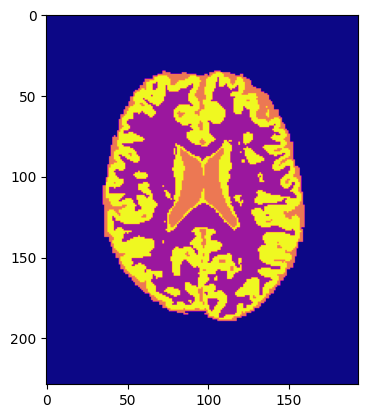

In [10]:
from sklearn.mixture import GaussianMixture

# Create the GaussianMixture model
model = GaussianMixture(n_components=3, random_state=42)

# Create the feature matrix X by reshaping slice2 into 2D array
X = slice2.reshape(-1, 1)

# Fit the model and predict the cluster labels
y_pred = model.fit_predict(X)

# Create array of 2D labels:

# Reshape the predicted labels to the original shape of mri_slice
labels2D = np.zeros(mri_slice.shape)

# Put the labels into fields with non-zero indices
labels2D[ind] = y_pred + 1

# Display the label image
plt.imshow(labels2D)
plt.set_cmap('plasma')

### Posterior probabilities

Probabilistic segmentation $p_{ik}$ gives us probability that pixel $i$ to belong the class $k$. These are in fact **posterior probabilities** $p(z_i=k|x_i, \mu_k, \sigma_k,c_k)$ for the labels $z_i$ given the intensity value $x_i$ and parameters $\mu_k, \sigma_k,c_k$ of the Gaussian intensity distribution for class $k$.

**Task 2.1:** Now let's plot how posterior probability for each class varies with pixel intensity value.

**Fill in the missing code below to display the probability curves. You will need to uncomment some lines.**

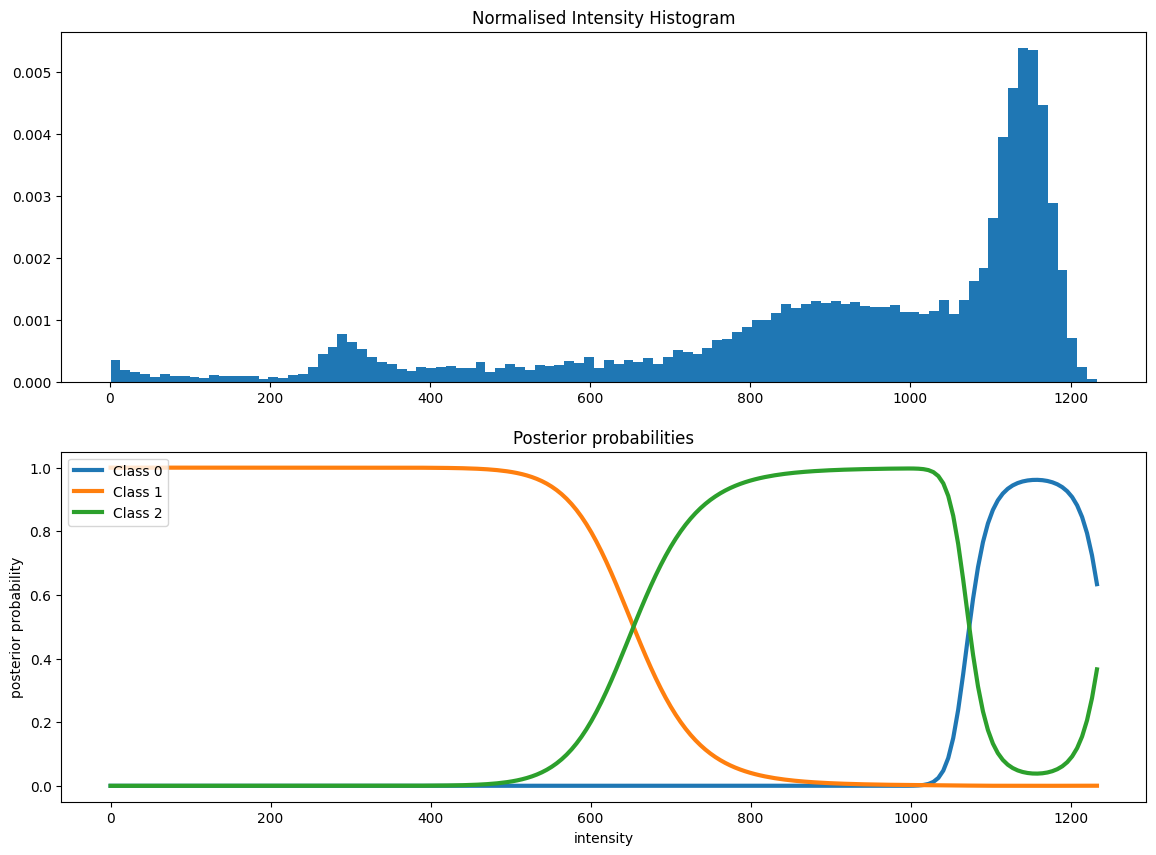

In [11]:
# Pixel intensity value range
intensity_range = np.linspace(0, np.max(slice2), 200)

# Predict posterior probabilities for the intensity range
# (Do not forget to reshape the intensity range to a 2D array for the prediction!)
proba_curves = model.predict_proba(intensity_range.reshape(-1, 1))

# Display
plt.figure(figsize = [14, 10])

# Plot normalised histogram
# The normalisation is achieved by parameter density
plt.subplot(211)
plt.hist(slice2, bins=100, density=True)
plt.title('Normalised Intensity Histogram')

# Plot posterior probabilities in a for loop
plt.subplot(212)
for i in range(0,3):
    plt.plot(intensity_range, proba_curves[:,i], linewidth=3, label='Class {}'.format(i))

# Annotate the subplot
plt.title('Posterior probabilities')
plt.xlabel('intensity')
plt.ylabel('posterior probability')
plt.legend(loc='upper left')
plt.show()

### Class-dependent likelihood

Class-dependent likelihoods are modelled by Gaussian distributions scaled by the mixing proportions
$$p(x_i|z_i=k,\mu_k,\sigma_k, c_k)=G(x_i,\mu_k,\sigma_k)c_k$$ 

To display these distributions over the normalised histogram (notice parameter `density=True`) we need to extract the `means_`, `covariances_` and `weights_` from the fitted `model`. Then we need to calculate the Gaussian distributions for these parameters. To do that we use function `norm.pdf` from `scipy.stats` module. Finally, these distributions need to be multiplied by the weights and plotted.

**Task 2.2:** Plot the Gaussian intensity distributions for each class $k$ over the normalised image histogram. 

**To do that, fill in the missing code below and run the cell. You will need to uncomment some lines.**

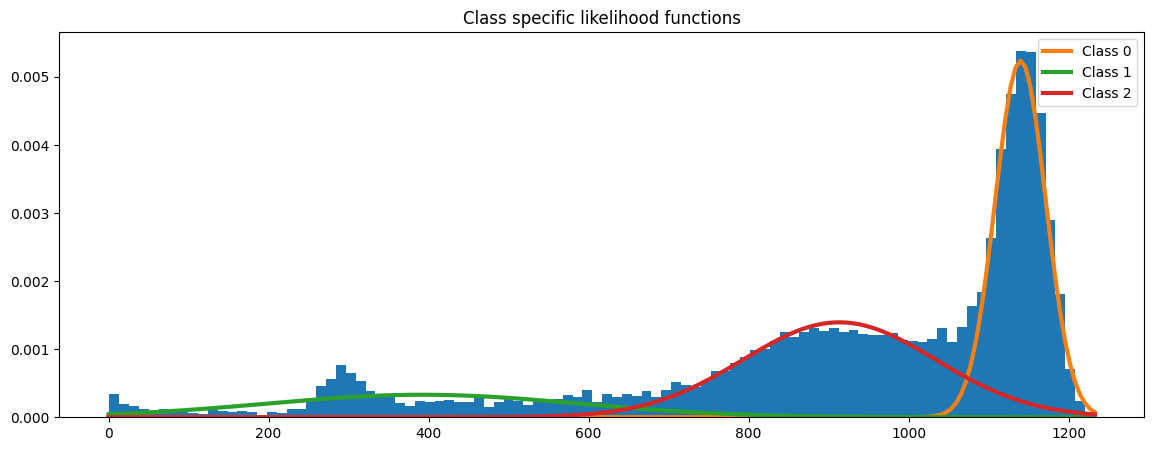

In [12]:
# To calculate gaussian distribution use the norm.pdf function

# Get parameters of GMM:
# Means
m = model.means_.flatten()  # Use flatten to make 1D arrays

# Standard deviation
s = np.sqrt(model.covariances_).flatten()

# Mixing proportions
w = model.weights_.flatten()

# Display
plt.figure(figsize = [14,5])

# Histogram
plt.hist(slice2, bins=100, density=True)

# Class-dependent likelihoods - Gaussian PDFs
for i in range(0,3):
    likelihood = w[i] * norm.pdf(intensity_range, m[i], s[i])
    plt.plot(intensity_range, likelihood, linewidth=3, label='Class {}'.format(i))
plt.legend()
plt.title('Class specific likelihood functions')
plt.show()

### Likelihood

The likelihood for each pixel intensity $x_i$ given the Gaussian Mixture Model parameters $\phi = (\mu_k,\sigma_k,c_k),k=1,...,K$ can be evaluated as
$$p(x_i|\phi)=\sum_{k=1}^KG(x_i,\mu_k,\sigma_k)c_k $$

We can calculate this function by adding the class-dependent likelihoods together. The alternative is to use a function provided by `GaussianMixture` model `score_samples` that returns **log-likelihood**.

**Task 2.3:** Plot the likelihood function for the whole intensity range over the normalised image histogram. 

**To do that, first evaluate log-likelihood over the intensity range, then calculate the exponential using `np.exp` and then plot it. You will need to uncomment some lines.**

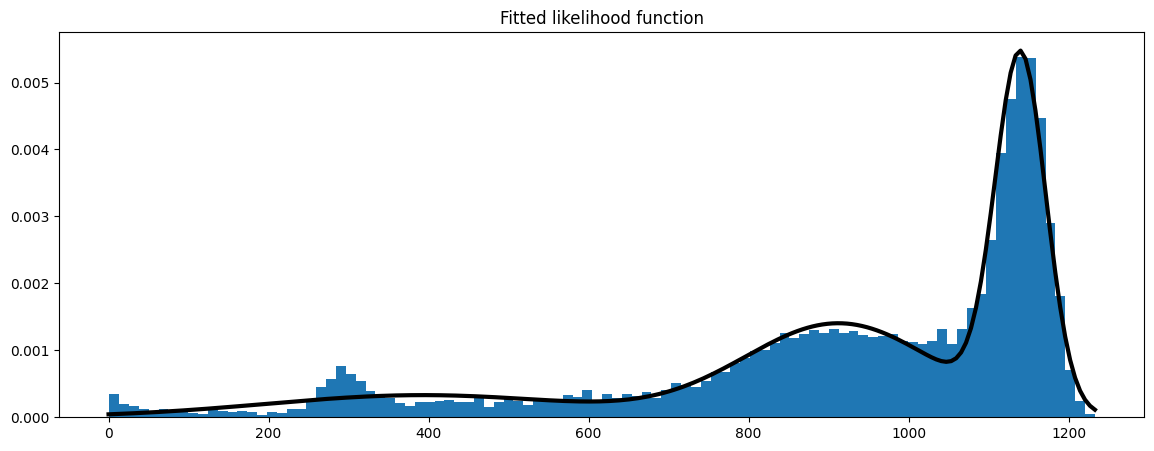

In [13]:
# Compare histogram with fitted Gaussian mixture likelihood function
plt.figure(figsize=[14, 5])

# Histogram
plt.hist(slice2, bins=100, density=True)

# Calculate likelihood
likelihood = np.exp(model.score_samples(intensity_range.reshape(-1, 1)))

# Plot likelihood
plt.plot(intensity_range, likelihood, linewidth=3, c='k')
plt.title('Fitted likelihood function')
plt.show()